# to get numbers for Table 2 in the technical 

CHange the line 2 in the second box to compare different methods of calculating a spectrum

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import csv

import scipy.optimize as op
import scipy.stats
from scipy.optimize import curve_fit
import scipy.io
from scipy.stats import rice

import random
import pickle
import seaborn as sns

import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats, wilcoxon,ttest_rel, pearsonr,shapiro,f_oneway, ranksums
from scipy.special import stdtr
import csv
import pandas as pd

from scipy.integrate import quad
import sys 
import os
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/PartialNephrectomy_Python"))
sys.path.append(os.path.abspath("/Users/miraliu/Desktop/PostDocCode/RenalAllograft_Python"))

#sys.path.append('../')
from ML_UsefulFunctions import *
from KidneyROIAnalyses import *
from RenalAllograftFunctions import *
from ML_Stats import *

from scipy import special

from scipy.integrate import tplquad

pd.options.display.float_format = '{:.3f}'.format

from scipy.stats import f_oneway


from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.simplefilter("ignore")

# CORRECTED...

In [16]:
fileloc = '/Users/miraliu/Desktop/Data/RA/RenalAllograft_IVIM/RA_DiffusionSpectra_IVIM_CORRECTED.xlsx'
Multiexp_Data = pd.read_excel(fileloc,sheet_name = 'Sortedfourpeaks_regdNNLS_8_fd') ## take2 or not here
Multiexp_Data["Record ID"] = Multiexp_Data["Record ID"].str.replace("_P", "_")

fileloc = '/Users/miraliu/Desktop/Data/RA/GCO202690RAMulticent-BanffScores_DATA_LABELS_2024-04-19_1316.xlsx'
RA_Database_Patients = pd.read_excel(fileloc, sheet_name = 'GCO202690RAMulticent-BanffScore',header = 0) 
RA_Database_Patients["Record ID"] = RA_Database_Patients["Record ID"].str.replace("_P", "_")


fileloc = '/Users/miraliu/Desktop/Data/RA/GCO202690RAMulticent-Octavia_DATA_LABELS_2024-04-18_1424.xlsx'
RA_wEGFR = pd.read_excel(fileloc, sheet_name = 'GCO202690RAMulticent-Octavia_DA',header = 0) 
RA_wEGFR["Record ID"] = RA_wEGFR["Record ID"].str.replace("_P", "_")


Cases_to_Run = pd.merge(Multiexp_Data, RA_Database_Patients[['Record ID', 'Interstitial Fibrosis Tubular Atrophy (ci+ct)']], how = 'inner', left_on=["Record ID"], right_on = ['Record ID'])
Cases_to_Run = Cases_to_Run.drop_duplicates(keep='first',ignore_index = True)

Cases_to_Run_cortical = Cases_to_Run.loc[Multiexp_Data['ROI Type'].str.endswith('C')]
Cases_to_Run_medullar = Cases_to_Run.loc[Multiexp_Data['ROI Type'].str.endswith('M')]

Cases_to_Run_cortical_Volunteer = Multiexp_Data.loc[Multiexp_Data['ROI Type'].str.endswith('C') & Multiexp_Data['ROI Type'].str.contains('V')  & Multiexp_Data['ROI Type'].str.contains('LK')]
Cases_to_Run_medullar_Volunteer = Multiexp_Data.loc[Multiexp_Data['ROI Type'].str.endswith('M') & Multiexp_Data['ROI Type'].str.contains('V') & Multiexp_Data['ROI Type'].str.contains('LK')]


In [17]:
RA_Database_Volunteer=Cases_to_Run_cortical_Volunteer
#RA_Database_Volunteer=RA_Database_Volunteer.drop(list(RA_Database_Volunteer)[42:], axis=1)




In [18]:

RA_Database_Patient  = Cases_to_Run.dropna(subset = 'Interstitial Fibrosis Tubular Atrophy (ci+ct)')
RA_Database_Patient = RA_Database_Patient.rename(columns={'Interstitial Fibrosis Tubular Atrophy (ci+ct)': 'IFTA'})

#RA_Database_Patient=RA_Database_Patient.drop(columns=list(RA_Database_Patient)[42:], axis=1)

In [19]:


RA_Database_Patient = pd.merge(RA_Database_Patient, RA_wEGFR[['Record ID', 'GFR CKD EPI']], how = 'inner', left_on=["Record ID"], right_on = ['Record ID'])
#RA_Database_Patient.insert(55, 'IFTA',RA_Database_Patient.pop('IFTA'))

RA_Database_Patient = RA_Database_Patient.drop_duplicates(subset=['Record ID'])

In [20]:
RA_Database_Patient = RA_Database_Patient.drop(RA_Database_Patient.filter(regex='result').columns, axis=1)
RA_Database_Patient = RA_Database_Patient.drop(RA_Database_Patient.filter(regex='rsq').columns, axis=1)
RA_Database_Patient = RA_Database_Patient.drop(RA_Database_Patient.filter(regex='peak').columns, axis=1)

RA_Database_Volunteer = RA_Database_Volunteer.drop(RA_Database_Volunteer.filter(regex='result').columns, axis=1)
RA_Database_Volunteer = RA_Database_Volunteer.drop(RA_Database_Volunteer.filter(regex='rsq').columns, axis=1)
RA_Database_Volunteer = RA_Database_Volunteer.drop(RA_Database_Volunteer.filter(regex='peak').columns, axis=1)


In [21]:
df = RA_Database_Patient.dropna(subset = 'IFTA')
df = df.dropna(subset = 'GFR CKD EPI')


## NOTE THE RENUMBERING IN ORDER OF DECREASE
df['allograft status'] = df['GFR CKD EPI']
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] == 0)] = 0 #'Healthy Function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] == 0)] = 1 #'No fibrosis impaired function'
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] > 0)] = 2 #'Fibrosis with normal function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] > 0)] = 3 #'Fibrosis with impaired function'


df_healthyallo = df.loc[df['allograft status']==  0]
df_impfunc = df.loc[df['allograft status'] == 1]
df_fibro = df.loc[df['allograft status'] == 2]
df_fibroimpfunc = df.loc[df['allograft status'] == 3]
df_anyclinical = df.loc[df['allograft status'] > 0]

df_healthyallo = df_healthyallo.drop(list(df_healthyallo)[69:71], axis=1)
df_impfunc=df_impfunc.drop(list(df_impfunc)[69:71], axis=1)
df_fibro= df_fibro.drop(list(df_fibro)[69:71], axis=1)
df_fibroimpfunc= df_fibroimpfunc.drop(list(df_fibroimpfunc)[69:71], axis=1)
df_anyclinical= df_anyclinical.drop(list(df_anyclinical)[69:71], axis=1)



In [22]:
def false_discovery_control(ps, *, axis=0, method='bh'):

    # Input Validation and Special Cases
    ps = np.asarray(ps)
    #print(ps)

    ps_in_range = (np.issubdtype(ps.dtype, np.number)
                   and np.all(ps == np.clip(ps, 0, 1)))
    #if not ps_in_range:
        #raise ValueError("`ps` must include only numbers between 0 and 1.")

    methods = {'bh', 'by'}
    if method.lower() not in methods:
        raise ValueError(f"Unrecognized `method` '{method}'."
                         f"Method must be one of {methods}.")
    method = method.lower()

    if axis is None:
        axis = 0
        ps = ps.ravel()

    axis = np.asarray(axis)[()]
    if not np.issubdtype(axis.dtype, np.integer) or axis.size != 1:
        raise ValueError("`axis` must be an integer or `None`")

    if ps.size <= 1 or ps.shape[axis] <= 1:
        return ps[()]

    ps = np.moveaxis(ps, axis, -1)
    m = ps.shape[-1]

    # Main Algorithm
    # Equivalent to the ideas of [1] and [2], except that this adjusts the
    # p-values as described in [3]. The results are similar to those produced
    # by R's p.adjust.

    # "Let [ps] be the ordered observed p-values..."
    order = np.argsort(ps, axis=-1)
    ps = np.take_along_axis(ps, order, axis=-1)  # this copies ps

    # Equation 1 of [1] rearranged to reject when p is less than specified q
    i = np.arange(1, m+1)
    ps *= m / i

    # Theorem 1.3 of [2]
    if method == 'by':
        ps *= np.sum(1 / i)

    # accounts for rejecting all null hypotheses i for i < k, where k is
    # defined in Eq. 1 of either [1] or [2]. See [3]. Starting with the index j
    # of the second to last element, we replace element j with element j+1 if
    # the latter is smaller.
    np.minimum.accumulate(ps[..., ::-1], out=ps[..., ::-1], axis=-1)

    # Restore original order of axes and data
    np.put_along_axis(ps, order, values=ps.copy(), axis=-1)
    ps = np.moveaxis(ps, -1, axis)

    return np.clip(ps, 0, 1)

In [23]:
# input two dataframes with matching columns, and calculate ranksums across all columns
def testranksums(df1, df2):
    comparisons = df1.columns
    dummy = np.empty((len(comparisons)-2,4),dtype=object)
    for j in range(2,len(comparisons)):
        out = scipy.stats.ranksums(df1[comparisons[j]], df2[comparisons[j]])
        dummy[j-2,:]=[comparisons[j], [round(df1[comparisons[j]].mean(),2), '±',round(df1[comparisons[j]].std(),2)], [round(df2[comparisons[j]].mean(),2),'±',round(df2[comparisons[j]].std(),2)], out[1]]
        #if out[1] < 0.09:
            #print('\n', comparisons[j])
            #print(round(df1[comparisons[j]].mean(),2), '±',round(df1[comparisons[j]].std(),2), 'vs.', round(df2[comparisons[j]].mean(),2),'±',round(df2[comparisons[j]].std(),2))
            #print('ranksum stat = ', round(out[0],2), 'p = ', round(out[1], 3))
    #print(dummy)   
    pval_df = pd.DataFrame({'Feature': dummy[:, 0], 'healthy': dummy[:,1],'pathological': dummy[:,2], 'p-value': dummy[:, 3]}).sort_values('p-value')
    pval_df = pval_df.replace(1, 0.999)
    #display(pval_df)
    corrected_p = false_discovery_control(pval_df['p-value'])
    corrected_p = [round(x, 3) for x in corrected_p]
    pval_df['bh p-value'] = corrected_p
    display(pval_df.loc[pval_df['p-value'] <= 0.05])

In [24]:
print('Healthy volunteer vs. Allografts with healthy function & no fibrosis', len(df_healthyallo))
testranksums(RA_Database_Volunteer, df_healthyallo)


Healthy volunteer vs. Allografts with healthy function & no fibrosis 13


,Feature,healthy,pathological,p-value,bh p-value
51,std slow fd,"[0.79, ±, 0.19]","[0.56, ±, 0.16]",0.027,0.633
30,mean D tissue,"[2.71, ±, 0.71]","[2.09, ±, 0.27]",0.034,0.633


In [25]:
print('Healthy volunteer vs. Allografts with impaired function & no fibrosis', len(df_impfunc))
testranksums(RA_Database_Volunteer, df_impfunc)


Healthy volunteer vs. Allografts with impaired function & no fibrosis 7


,Feature,healthy,pathological,p-value,bh p-value
51,std slow fd,"[0.79, ±, 0.19]","[0.48, ±, 0.19]",0.042,0.466
5,mean f tubule,"[0.11, ±, 0.04]","[0.05, ±, 0.05]",0.042,0.466
32,std D tissue,"[1.02, ±, 0.24]","[0.6, ±, 0.31]",0.042,0.466
7,std f tubule,"[0.15, ±, 0.03]","[0.09, ±, 0.05]",0.042,0.466
10,mean f tissue,"[0.73, ±, 0.05]","[0.83, ±, 0.07]",0.042,0.466


In [26]:
print('Healthy volunteer vs. Allografts with healthy function & fibrosis',len(df_fibro))
testranksums(RA_Database_Volunteer, df_fibro)


Healthy volunteer vs. Allografts with healthy function & fibrosis 15


,Feature,healthy,pathological,p-value,bh p-value
5,mean f tubule,"[0.11, ±, 0.04]","[0.04, ±, 0.04]",0.006,0.204
7,std f tubule,"[0.15, ±, 0.03]","[0.09, ±, 0.06]",0.016,0.204
10,mean f tissue,"[0.73, ±, 0.05]","[0.85, ±, 0.09]",0.016,0.204
11,median f tissue,"[0.74, ±, 0.05]","[0.89, ±, 0.11]",0.021,0.204
46,mean med fd,"[1.25, ±, 0.5]","[0.52, ±, 0.54]",0.021,0.204
32,std D tissue,"[1.02, ±, 0.24]","[0.65, ±, 0.26]",0.026,0.204
51,std slow fd,"[0.79, ±, 0.19]","[0.52, ±, 0.2]",0.026,0.204
25,mean D tubule,"[7.97, ±, 2.34]","[3.99, ±, 4.76]",0.032,0.223
52,mean fibro fd,"[0.07, ±, 0.02]","[0.04, ±, 0.02]",0.050,0.303


In [27]:
print('Healthy volunteer vs. Allografts with impaired function & fibrosis', len(df_fibroimpfunc))
testranksums(RA_Database_Volunteer, df_fibroimpfunc)


Healthy volunteer vs. Allografts with impaired function & fibrosis 19


,Feature,healthy,pathological,p-value,bh p-value
7,std f tubule,"[0.15, ±, 0.03]","[0.09, ±, 0.05]",0.009,0.330
51,std slow fd,"[0.79, ±, 0.19]","[0.52, ±, 0.18]",0.014,0.330
5,mean f tubule,"[0.11, ±, 0.04]","[0.05, ±, 0.04]",0.021,0.330
10,mean f tissue,"[0.73, ±, 0.05]","[0.82, ±, 0.08]",0.025,0.330
11,median f tissue,"[0.74, ±, 0.05]","[0.85, ±, 0.11]",0.030,0.330
32,std D tissue,"[1.02, ±, 0.24]","[0.7, ±, 0.29]",0.036,0.330
30,mean D tissue,"[2.71, ±, 0.71]","[2.13, ±, 0.27]",0.043,0.336


In [28]:
print('Healthy volunteer vs. Allografts with any bad', len(df_anyclinical))
testranksums(RA_Database_Volunteer, df_anyclinical)


Healthy volunteer vs. Allografts with any bad 41


,Feature,healthy,pathological,p-value,bh p-value
5,mean f tubule,"[0.11, ±, 0.04]","[0.05, ±, 0.04]",0.007,0.158
7,std f tubule,"[0.15, ±, 0.03]","[0.09, ±, 0.05]",0.007,0.158
51,std slow fd,"[0.79, ±, 0.19]","[0.51, ±, 0.18]",0.011,0.158
10,mean f tissue,"[0.73, ±, 0.05]","[0.83, ±, 0.08]",0.012,0.158
32,std D tissue,"[1.02, ±, 0.24]","[0.66, ±, 0.28]",0.017,0.158
11,median f tissue,"[0.74, ±, 0.05]","[0.86, ±, 0.1]",0.017,0.158
46,mean med fd,"[1.25, ±, 0.5]","[0.62, ±, 0.64]",0.027,0.215
30,mean D tissue,"[2.71, ±, 0.71]","[2.13, ±, 0.32]",0.036,0.246
25,mean D tubule,"[7.97, ±, 2.34]","[4.49, ±, 4.39]",0.046,0.195


# making box plot


In [29]:
RA_Database_Volunteer['allograft status'] = -1
df['allograft status'] = df['GFR CKD EPI']
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] == 0)] = 0 #'Healthy Function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] == 0)] =2 #'No fibrosis impaired function'
df['allograft status'].loc[(df['GFR CKD EPI'] > 45) &(df['IFTA'] > 0)] = 3 #'Fibrosis with normal function'
df['allograft status'].loc[(df['GFR CKD EPI'] <= 45) &(df['IFTA'] > 0)] = 1 #'Fibrosis with impaired function'


df_boxplot = pd.concat([df[['Record ID', 'mean med fd', 'median med fd', 'allograft status']], RA_Database_Volunteer[['Record ID', 'mean med fd', 'median med fd', 'allograft status']]])



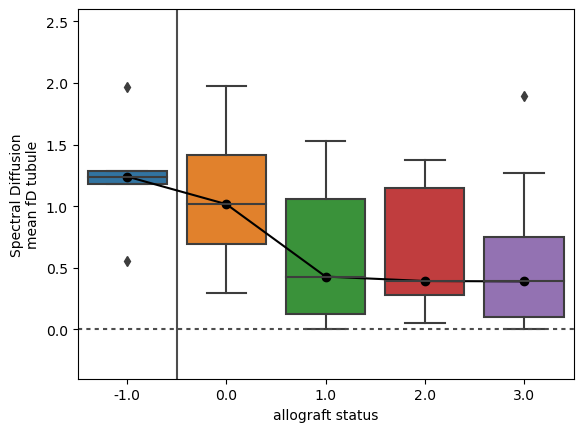

In [30]:
sns.boxplot(x=df_boxplot["allograft status"], y=df_boxplot["mean med fd"])#,showmeans=True )
pl.axvline(.5, color=".3")#, dashes=(2, 2))
pl.axhline(0, color=".3", dashes=(2, 2))
pl.ylim(-.4, 2.6)
pl.scatter([0,1,2,3,4], [np.median(RA_Database_Volunteer['mean med fd']), np.median(df_healthyallo['mean med fd']), np.median(df_fibroimpfunc['mean med fd']), np.median(df_impfunc['mean med fd']), np.median(df_fibro['mean med fd'])], color = 'black')
pl.plot([0,1,2,3,4], [np.median(RA_Database_Volunteer['mean med fd']), np.median(df_healthyallo['mean med fd']), np.median(df_fibroimpfunc['mean med fd']), np.median(df_impfunc['mean med fd']),np.median(df_fibro['mean med fd'])], color = 'black', linestyle = '-')
pl.ylabel('Spectral Diffusion\nmean fD tubule')

pl.show()

In [31]:
print(np.mean(RA_Database_Volunteer['mean slow fd']), np.mean(df_healthyallo['mean slow fd']), np.mean(df_fibroimpfunc['mean slow fd']), np.mean(df_impfunc['mean slow fd']),np.mean(df_fibro['mean slow fd']))
print(np.std(RA_Database_Volunteer['mean slow fd']), np.std(df_healthyallo['mean slow fd']), np.std(df_fibroimpfunc['mean slow fd']), np.std(df_impfunc['mean slow fd']),np.std(df_fibro['mean slow fd']))


2.14552394236982 1.670109156415073 1.8676825002093944 1.7620287799467413 2.0660004862418835
0.5904278953054277 0.32347547089896594 0.19616492491349488 0.3580870020498986 0.3493740925436278


In [33]:
print(112.5*np.mean(RA_Database_Volunteer['mean fast fd']), 112.5*np.mean(df_healthyallo['mean fast fd']), 112.5*np.mean(df_fibroimpfunc['mean fast fd']), 112.5*np.mean(df_impfunc['mean fast fd']), 112.5*np.mean(df_fibro['mean fast fd']))
print(112.5*np.std(RA_Database_Volunteer['mean fast fd']), 112.5*np.std(df_healthyallo['mean fast fd']), 112.5*np.std(df_fibroimpfunc['mean fast fd']), 112.5*np.std(df_impfunc['mean fast fd']), 112.5*np.std(df_fibro['mean fast fd']))


925.7210892825412 1197.9047068944346 915.603628312867 1026.0929008982773 777.7890837380696
477.45597254833785 518.384777221144 638.2648144191843 538.888772607894 745.7132936522265


In [34]:
print(112.5*np.mean(RA_Database_Volunteer['mean med fd']), 112.5*np.mean(df_healthyallo['mean med fd']), 112.5*np.mean(df_fibroimpfunc['mean med fd']), 112.5*np.mean(df_impfunc['mean med fd']),112.5*np.mean(df_fibro['mean med fd']))
print(112.5*np.std(RA_Database_Volunteer['mean med fd']), 112.5*np.std(df_healthyallo['mean med fd']), 112.5*np.std(df_fibroimpfunc['mean med fd']), 112.5*np.std(df_impfunc['mean med fd']),112.5*np.std(df_fibro['mean med fd']))


140.1926879030178 127.16208830572789 78.18552418169456 75.20490866107572 58.0289925532454
50.57354572759497 77.30477686544035 82.5998697007492 55.922070141490074 58.62454810359722
